## Explain fitted model

This notebook and associated modules fits a Random Forest model using the optimal hyperparameters obtained during the hyperparameter tuning.  It then extracts the feature importance and generates Shap values on the top features

In [ ]:
import pandas as pd
import numpy as np

#!pip install shap
import shap

import data_import_and_preprocessing as preprocess
import rf_importance_plot as rf_imp
import get_shap_values as get_shap

In [ ]:
# create a list of the features to use for modeling

feat_list = [
    "CUST_PRICE_SENSITIVITY",
    "CUST_LIFESTAGE",
    "BASKET_SIZE_PROP_SPEND_PROD_CODE_M",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA",
    "DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON",
    "BASKET_SIZE_PROP_VISITS_CUST_CODE_L",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh",
    "BASKET_TYPE_PROP_VISITS_CUST_CODE_Small Shop",
    "BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_MS",
    "CHNG_VISITS_PROD_CODE_30_1_52",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_LS",
    "STORE_FORMAT_PROP_QUANTITY_CUST_CODE_SS",
    "BASKET_SIZE_QUANTITY_CUST_CODE_S",
    "BASKET_DOMINANT_MISSION_PROP_QUANTITY_PROD_CODE_Nonfood",
    "CHNG_SPEND_PROD_CODE_40_8_52",
    "BASKET_DOMINANT_MISSION_PROP_VISITS_CUST_CODE_XX",
    "BASKET_TYPE_VISITS_CUST_CODE_XX",
    "WKDAY_WKEND_PROP_QUANTITY_CUST_CODE_WEEKEND",
    "BASKET_TYPE_QUANTITY_CUST_CODE_Small Shop",
    "SPEND_PROD_CODE_30_52",
    "BASKET_TYPE_SPEND_CUST_CODE_Top Up",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_CUST_CODE_Grocery",
    "CHNG_QUANTITY_PROD_CODE_40_26_52",
    "SPEND_PROD_CODE_20_52",
    "BASKET_TYPE_PROP_QUANTITY_CUST_CODE_Top Up",
    "VISITS_PROD_CODE_20_52",
    "WKDAY_WKEND_PROP_VISITS_PROD_CODE_WEEKEND",
    "VISITS_PROD_CODE_40_1",
    "CHNG_VISITS_PROD_CODE_40_1_26",
    "BASKET_TYPE_PROP_SPEND_PROD_CODE_XX",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_XLS",
    "DAY_PART_PROP_VISITS_CUST_CODE_EVENING",
    "TIME_BTWN_MEDIAN_OVERALL_PROD_CODE_40",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_XLS",
    "DAY_PART_PROP_SPEND_PROD_CODE_MORNING",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_SS",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_MS",
    "DAY_PART_PROP_SPEND_CUST_CODE_MORNING",
    "BASKET_PRICE_SENSITIVITY_PROP_SPEND_PROD_CODE_LA",
    "DAY_PART_PROP_QUANTITY_PROD_CODE_EVENING",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_UM",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Grocery",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_PROD_CODE_MM",
    "STORE_FORMAT_PROP_SPEND_CUST_CODE_LS",
    "QUANTITY_PROD_CODE_52",
    "BASKET_TYPE_PROP_VISITS_PROD_CODE_Top Up",
    "DAY_PART_PROP_SPEND_PROD_CODE_AFTERNOON",
    "CHNG_VISITS_PROD_CODE_20_1_8",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_CUST_CODE_MM",
    "BASKET_DOMINANT_MISSION_SPEND_CUST_CODE_XX",
    "USER_factor_0",
    "USER_factor_1",
    "USER_factor_2",
    "USER_factor_3",
    "USER_factor_4",
    "ITEM_factor_0",
    "ITEM_factor_1",
    "ITEM_factor_2",
    "ITEM_factor_3",
    "ITEM_factor_4",
]

### Download the training and test data from S3

In [3]:
train_df, test_df = preprocess.download_data(
    bucket="udacity-machine-learning-capstone-data",
    train_key="train_df_features.csv",
    test_key="test_df_features.csv",
    feat_list=feat_list,
)
train_df.head()

,TARGET,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_SIZE_PROP_SPEND_PROD_CODE_M,BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA,DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON,BASKET_SIZE_PROP_VISITS_CUST_CODE_L,BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh,BASKET_TYPE_PROP_VISITS_CUST_CODE_Small_Shop,BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L,...,USER_factor_0,USER_factor_1,USER_factor_2,USER_factor_3,USER_factor_4,ITEM_factor_0,ITEM_factor_1,ITEM_factor_2,ITEM_factor_3,ITEM_factor_4
0,0.0,MM,YA,0.125,0.00,0.604729,0.071429,0.625,0.785714,0.875,...,0.026464,0.029529,0.028840,0.029235,-0.016864,0.071327,0.125177,0.096613,0.053999,0.011342
1,0.0,UM,YF,0.125,0.00,0.622533,1.000000,0.625,0.000000,0.875,...,0.382273,0.345985,0.039953,0.293179,0.331691,0.071327,0.125177,0.096613,0.053999,0.011342
2,0.0,LA,XX,0.125,0.51,0.000000,0.333333,0.625,0.333333,0.875,...,-0.000552,0.005104,0.009202,-0.001290,0.006224,0.071327,0.125177,0.096613,0.053999,0.011342
3,1.0,MM,OT,0.125,10.48,0.662855,0.531250,0.625,0.187500,0.875,...,0.152681,0.325770,0.110216,0.223827,0.193619,0.071327,0.125177,0.096613,0.053999,0.011342
4,1.0,LA,XX,0.125,292.80,0.549789,0.592593,0.625,0.283951,0.875,...,0.089672,-0.011940,0.497162,0.104124,0.277687,0.071327,0.125177,0.096613,0.053999,0.011342


### Pre-process the training and test data

Further split the training data into training and test DataFrames (reserving the current test DataFrame for validation).  Standardize the numeric features and one-hot encode the categorical features

In [4]:
train_df, test_df, valid_df = preprocess.preprocess(train_df, test_df, 0.3)

Standardizing numeric features
One-hot encode the categorical features


In [5]:
train_df.head()

,onehotencoder__x0_LA,onehotencoder__x0_MM,onehotencoder__x0_UM,onehotencoder__x0_XX,onehotencoder__x1_OA,onehotencoder__x1_OF,onehotencoder__x1_OT,onehotencoder__x1_PE,onehotencoder__x1_XX,onehotencoder__x1_YA,...,USER_factor_1,USER_factor_2,USER_factor_3,USER_factor_4,ITEM_factor_0,ITEM_factor_1,ITEM_factor_2,ITEM_factor_3,ITEM_factor_4,TARGET
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.851561,-0.499044,-0.452179,-0.460927,-0.795604,-0.988080,-0.670047,-0.240992,-0.731895,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.255877,-0.561491,-0.317252,-0.341696,-0.553736,0.031931,0.500478,-0.309449,0.379014,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.265735,-0.643920,-0.160998,-0.013396,-0.684042,-0.526075,-0.250000,-0.708231,-0.020172,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.210331,-0.340076,-0.490424,-0.299016,-0.781666,0.027252,-1.060071,-0.079952,-0.051054,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.556035,-0.773609,0.399505,0.617726,-1.121694,0.019708,-0.073301,1.966509,0.149696,1.0


### Get Random Forest Importance

Train a Random Forest model on the training DataFrame using the 'best' hyperparameters from the tuning runs.  Get the feature importance and save a DataFrame containing only the top features (and the target variable)

Training Random Forest model


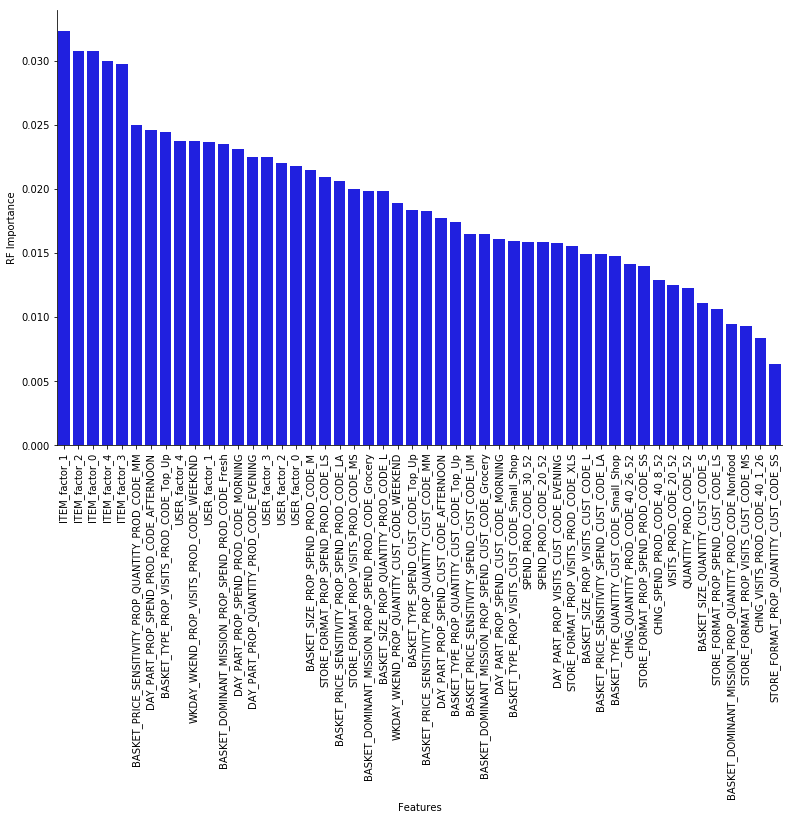

In [6]:
plt, top_features_list = rf_imp.get_rf_importance(
    train_df=train_df, n_estimators=236, max_features="log2", max_depth=12, top_n=50
)

In [7]:
top_features_list

['ITEM_factor_1',
 'ITEM_factor_2',
 'ITEM_factor_0',
 'ITEM_factor_4',
 'ITEM_factor_3',
 'BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_PROD_CODE_MM',
 'DAY_PART_PROP_SPEND_PROD_CODE_AFTERNOON',
 'BASKET_TYPE_PROP_VISITS_PROD_CODE_Top_Up',
 'USER_factor_4',
 'WKDAY_WKEND_PROP_VISITS_PROD_CODE_WEEKEND',
 'USER_factor_1',
 'BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh',
 'DAY_PART_PROP_SPEND_PROD_CODE_MORNING',
 'DAY_PART_PROP_QUANTITY_PROD_CODE_EVENING',
 'USER_factor_3',
 'USER_factor_2',
 'USER_factor_0',
 'BASKET_SIZE_PROP_SPEND_PROD_CODE_M',
 'STORE_FORMAT_PROP_SPEND_PROD_CODE_LS',
 'BASKET_PRICE_SENSITIVITY_PROP_SPEND_PROD_CODE_LA',
 'STORE_FORMAT_PROP_VISITS_PROD_CODE_MS',
 'BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Grocery',
 'BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L',
 'WKDAY_WKEND_PROP_QUANTITY_CUST_CODE_WEEKEND',
 'BASKET_TYPE_SPEND_CUST_CODE_Top_Up',
 'BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_CUST_CODE_MM',
 'DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON',
 'BASKET_TYPE_PROP_QUANTITY_CUST_CODE_Top_Up',
 'BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_UM',
 'BASKET_DOMINANT_MISSION_PROP_SPEND_CUST_CODE_Grocery',
 'DAY_PART_PROP_SPEND_CUST_CODE_MORNING',
 'BASKET_TYPE_PROP_VISITS_CUST_CODE_Small_Shop',
 'SPEND_PROD_CODE_30_52',
 'SPEND_PROD_CODE_20_52',
 'DAY_PART_PROP_VISITS_CUST_CODE_EVENING',
 'STORE_FORMAT_PROP_VISITS_PROD_CODE_XLS',
 'BASKET_SIZE_PROP_VISITS_CUST_CODE_L',
 'BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA',
 'BASKET_TYPE_QUANTITY_CUST_CODE_Small_Shop',
 'CHNG_QUANTITY_PROD_CODE_40_26_52',
 'STORE_FORMAT_PROP_SPEND_PROD_CODE_SS',
 'CHNG_SPEND_PROD_CODE_40_8_52',
 'VISITS_PROD_CODE_20_52',
 'QUANTITY_PROD_CODE_52',
 'BASKET_SIZE_QUANTITY_CUST_CODE_S',
 'STORE_FORMAT_PROP_SPEND_CUST_CODE_LS',
 'BASKET_DOMINANT_MISSION_PROP_QUANTITY_PROD_CODE_Nonfood',
 'STORE_FORMAT_PROP_VISITS_CUST_CODE_MS',
 'CHNG_VISITS_PROD_CODE_40_1_26',
 'STORE_FORMAT_PROP_QUANTITY_CUST_CODE_SS',
 'TARGET']

### Get Shap Values

Get the Shap values on the top features from the RF Importance

In [9]:
shap_values = get_shap.get_shap_values(
    df=train_df,
    top_features_list=top_features_list,
    n_estimators=236,
    max_features='log2',
    max_depth=12,
)

Training Random Forest model
Generating Shap values


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


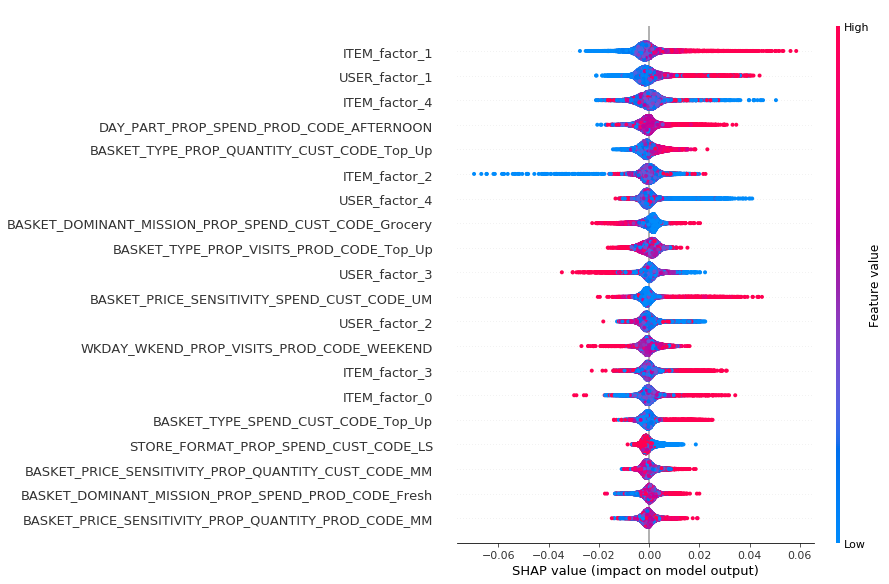

In [21]:
top_features = train_df.loc[:, top_features_list]
top_features.drop("TARGET", axis=1, inplace=True)

shap.summary_plot(shap_values[1], top_features)

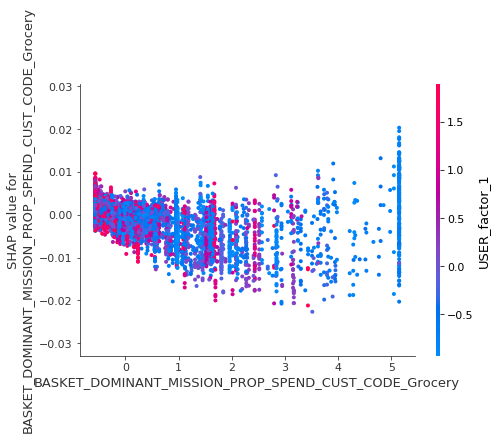

In [22]:
shap.dependence_plot(
    "BASKET_DOMINANT_MISSION_PROP_SPEND_CUST_CODE_Grocery",
    shap_values[1],
    top_features,
    interaction_index="USER_factor_1",
)

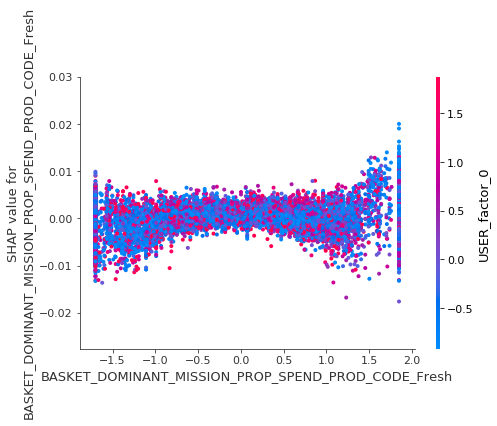

In [23]:
shap.dependence_plot(
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh",
    shap_values[1],
    top_features,
    interaction_index="USER_factor_0",
)

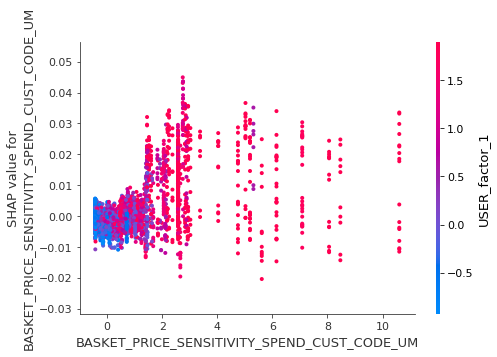

In [24]:
shap.dependence_plot(
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_UM",
    shap_values[1],
    top_features,
    interaction_index="USER_factor_1",
)

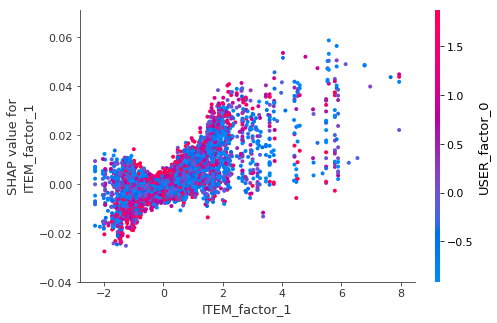

In [25]:
shap.dependence_plot(
    "ITEM_factor_1", shap_values[1], top_features, interaction_index="USER_factor_0"
)

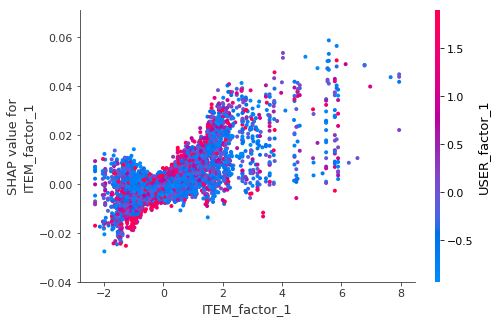

In [26]:
shap.dependence_plot(
    "ITEM_factor_1", shap_values[1], top_features, interaction_index="USER_factor_1"
)

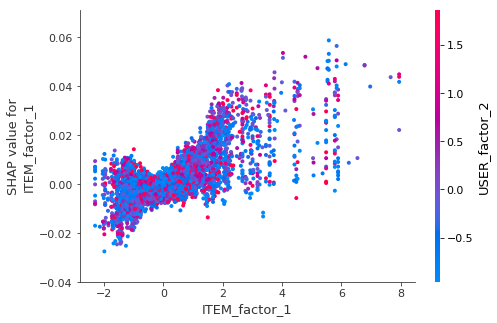

In [27]:
shap.dependence_plot(
    "ITEM_factor_1", shap_values[1], top_features, interaction_index="USER_factor_2"
)

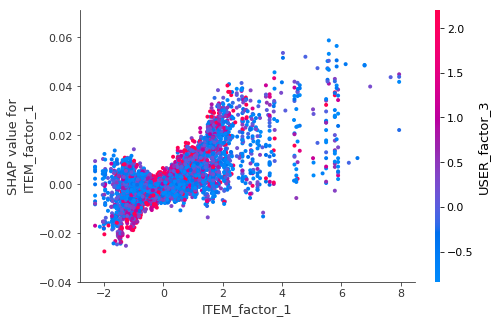

In [28]:
shap.dependence_plot(
    "ITEM_factor_1", shap_values[1], top_features, interaction_index="USER_factor_3"
)

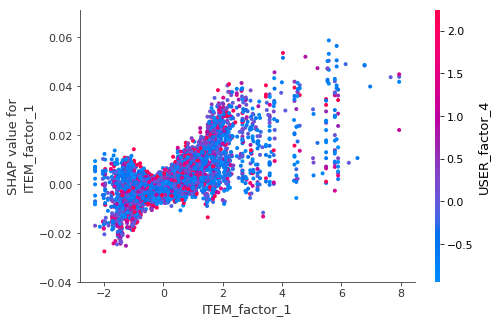

In [29]:
shap.dependence_plot(
    "ITEM_factor_1", shap_values[1], top_features, interaction_index="USER_factor_4"
)

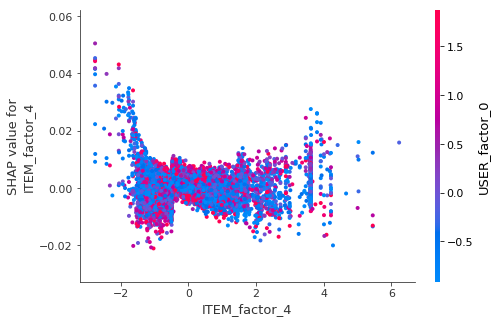

In [30]:
shap.dependence_plot(
    "ITEM_factor_4", shap_values[1], top_features, interaction_index="USER_factor_0"
)

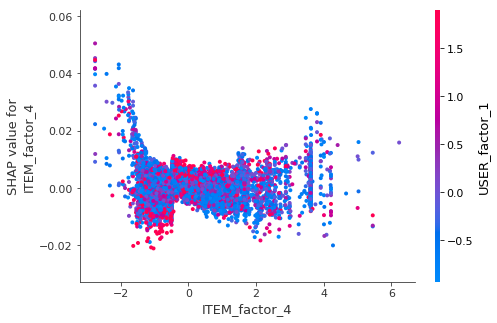

In [31]:
shap.dependence_plot(
    "ITEM_factor_4", shap_values[1], top_features, interaction_index="USER_factor_1"
)

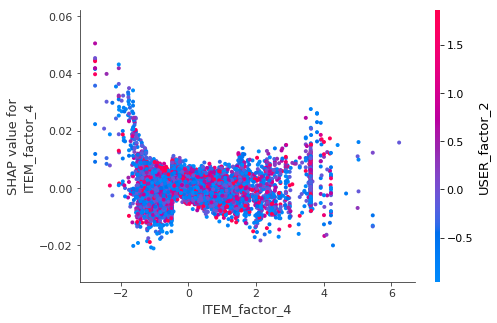

In [32]:
shap.dependence_plot(
    "ITEM_factor_4", shap_values[1], top_features, interaction_index="USER_factor_2"
)

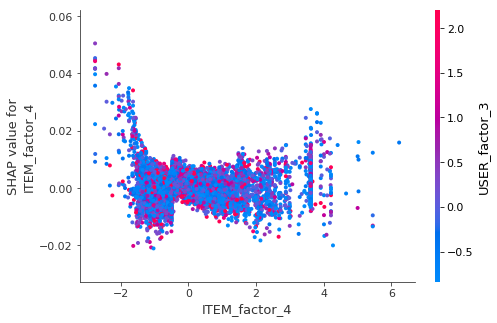

In [33]:
shap.dependence_plot(
    "ITEM_factor_4", shap_values[1], top_features, interaction_index="USER_factor_3"
)

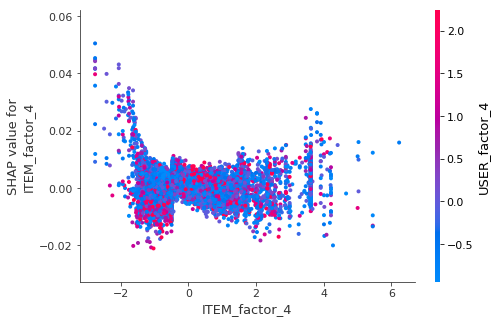

In [34]:
shap.dependence_plot(
    "ITEM_factor_4", shap_values[1], top_features, interaction_index="USER_factor_4"
)

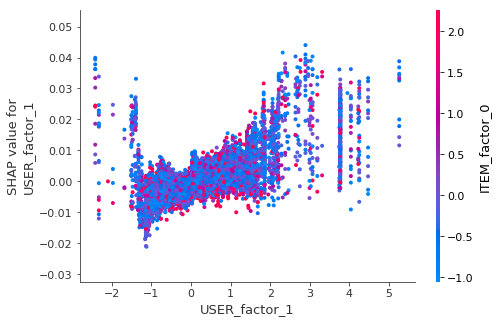

In [35]:
shap.dependence_plot(
    "USER_factor_1", shap_values[1], top_features, interaction_index="ITEM_factor_0"
)

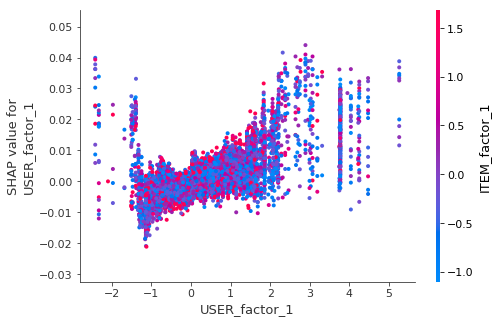

In [36]:
shap.dependence_plot(
    "USER_factor_1", shap_values[1], top_features, interaction_index="ITEM_factor_1"
)

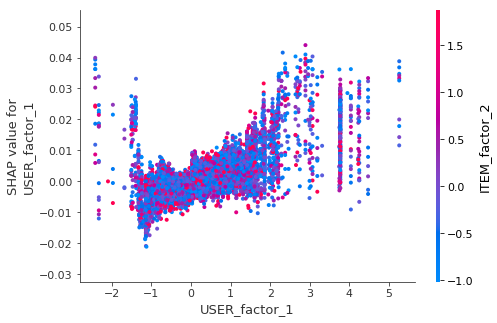

In [37]:
shap.dependence_plot(
    "USER_factor_1", shap_values[1], top_features, interaction_index="ITEM_factor_2"
)

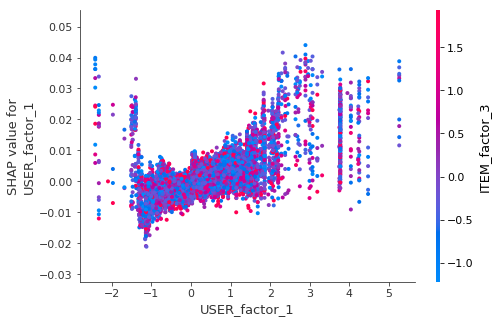

In [38]:
shap.dependence_plot(
    "USER_factor_1", shap_values[1], top_features, interaction_index="ITEM_factor_3"
)

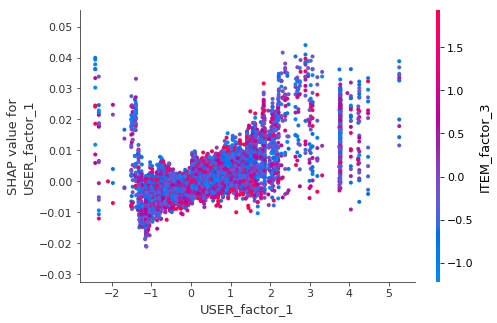

In [39]:
shap.dependence_plot(
    "USER_factor_1", shap_values[1], top_features, interaction_index="ITEM_factor_3"
)